https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 50 e top 100)
    * Seleção de atributos com teste ANOVA (top 50 e top 100)
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Undersample
        * Near Miss
    * Oversample
        * Resample
        * ROS
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Random Forest
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * Logistic Regression
        * KNN
        * Naive Bayes
    * Métricas de desempenho
        * F1-score
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

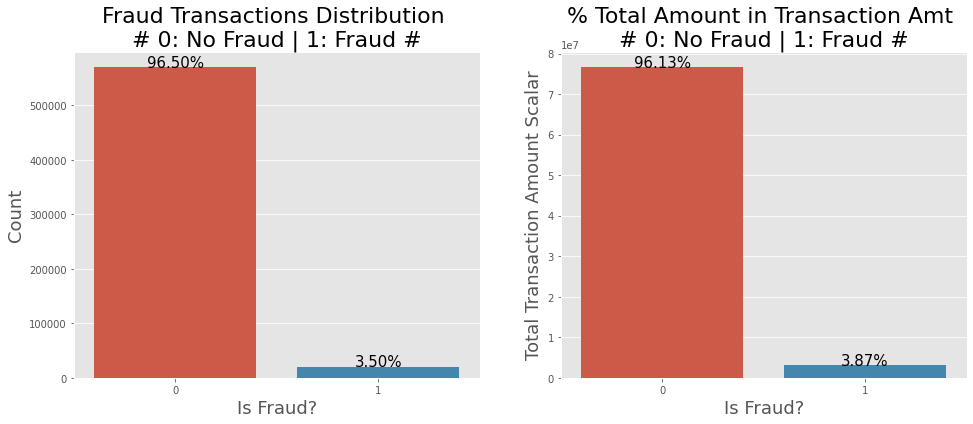

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 99.19615944728554%
id_25: 99.13096487960172%
id_26: 99.12571544687913%
id_27: 99.1246994276425%
id_28: 76.12727334304196%
id_29: 76.12727334304196%
id_30: 86.86541131845429%
id_31: 76.24513157449114%
id_32: 86.86185525112609%
id_33: 87.58949436109323%
id_34: 86.82477054898906%
id_35: 76.12608798726589%
id_36: 76.12608798726589%
id_37: 76.12608798726589%
id_38: 76.12608798726589%
DeviceType: 76.15572188166763%
DeviceInfo: 79.90551021099333%
Date: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int64,0,2,0,0,0,0.220000000000000
1,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
2,ProductCD,object,0,5,W,W,W,1.280000000000000
3,card1,int64,0,13553,13926,2755,4663,9.970000000000001
4,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
5,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
6,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000
7,addr1,float64,65706,332,315.0,325.0,330.0,5.060000000000000
8,dist1,float64,352271,2651,19.0,NaN,287.0,6.340000000000000
9,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.680000000000000


In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


,Name,dtypes


In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


,Name,dtypes


In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# separando a coluna target
X = train.drop('isFraud',axis = 1)
y = train['isFraud'].astype('uint8')

In [56]:
y.value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [57]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [58]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


# Balanceamento de Classes

## Undersample

### Undersampling com Near Miss

In [59]:
from imblearn.under_sampling import NearMiss

In [60]:
nm = NearMiss()

In [61]:
%%time
X_train_undersample_with_near_miss, y_train_undersample_with_near_miss = nm.fit_resample(X_train, y_train)
X_test_undersample_with_near_miss, y_test_undersample_with_near_miss = nm.fit_resample(X_test, y_test)

CPU times: user 2min 9s, sys: 849 ms, total: 2min 10s
Wall time: 12.1 s


In [62]:
# combinando as classes minoritária com a majoritária subamostrada
train_undersample_with_near_miss = pd.concat([X_train_undersample_with_near_miss, y_train_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_undersample_with_near_miss.isFraud.value_counts()

isFraud
0    16530
1    16530
Name: count, dtype: int64

In [63]:
# combinando as classes minoritária com a majoritária subamostrada
test_undersample_with_near_miss = pd.concat([X_test_undersample_with_near_miss, y_test_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_undersample_with_near_miss.isFraud.value_counts()

isFraud
0    4133
1    4133
Name: count, dtype: int64

## Oversample

### Resample

In [64]:
from sklearn.utils import resample

In [65]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [66]:
%%time
train_split_not_fraud = train_split[train_split.isFraud == 0]
train_split_fraud = train_split[train_split.isFraud == 1]

test_split_not_fraud = test_split[test_split.isFraud == 0]
test_split_fraud = test_split[test_split.isFraud == 1]

CPU times: user 118 ms, sys: 12.1 ms, total: 130 ms
Wall time: 129 ms


In [67]:
%%time
train_split_fraud_upsampled = resample(train_split_fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(train_split_not_fraud), # match number in majority class
                           random_state = 27)

CPU times: user 83.3 ms, sys: 12.6 ms, total: 96 ms
Wall time: 95.2 ms


In [68]:
%%time
test_split_fraud_upsampled = resample(test_split_fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(test_split_not_fraud), # match number in majority class
                           random_state = 27)

CPU times: user 22.7 ms, sys: 65 µs, total: 22.8 ms
Wall time: 22 ms


In [69]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_resample = pd.concat([train_split_not_fraud, train_split_fraud_upsampled])

# contando as classes minoritária e majoritária
train_oversample_with_resample.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [70]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_resample = pd.concat([test_split_not_fraud, test_split_fraud_upsampled])

# contando as classes minoritária e majoritária
test_oversample_with_resample.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

In [71]:
X_train_oversample_with_resample = train_oversample_with_resample.drop('isFraud',axis = 1)
y_train_oversample_with_resample = train_oversample_with_resample['isFraud'].astype('uint8')

In [72]:
X_test_oversample_with_resample = test_oversample_with_resample.drop('isFraud',axis = 1)
y_test_oversample_with_resample = test_oversample_with_resample['isFraud'].astype('uint8')

### Random over-sampling

In [73]:
from imblearn.over_sampling import RandomOverSampler

In [74]:
ros = RandomOverSampler(random_state=42)

In [75]:
%%time
X_train_oversample_with_ros, y_train_oversample_with_ros = ros.fit_resample(X_train, y_train)
X_test_oversample_with_ros, y_test_oversample_with_ros = ros.fit_resample(X_test, y_test)

CPU times: user 2.18 s, sys: 348 ms, total: 2.53 s
Wall time: 2.53 s


In [76]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_ros = pd.concat([X_train_oversample_with_ros, y_train_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_ros.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [77]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_ros = pd.concat([X_test_oversample_with_ros, y_test_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_ros.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

### Oversampling com SMOTE

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
smote = SMOTE(random_state=42)

In [80]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)
X_test_oversample_with_smote, y_test_oversample_with_smote = smote.fit_resample(X_test, y_test)

CPU times: user 7.39 s, sys: 528 ms, total: 7.92 s
Wall time: 3.13 s


In [81]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [82]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_smote = pd.concat([X_test_oversample_with_smote, y_test_oversample_with_smote], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_smote.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

### Oversampling com Borderline-SMOTE

In [83]:
from imblearn.over_sampling import BorderlineSMOTE

In [84]:
smote = BorderlineSMOTE(random_state=42)

In [85]:
%%time
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)
X_test_oversample_with_borderline_smote, y_test_oversample_with_borderline_smote = smote.fit_resample(X_test, y_test)

CPU times: user 2min 15s, sys: 623 ms, total: 2min 16s
Wall time: 14.7 s


In [86]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                                    y_train_oversample_with_borderline_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [87]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_borderline_smote = pd.concat([X_test_oversample_with_borderline_smote, \
                                                   y_test_oversample_with_borderline_smote], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

### Oversampling com AdaSyn

In [88]:
from imblearn.over_sampling import ADASYN

In [89]:
adasyn = ADASYN(random_state=42)

In [90]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)
X_test_oversample_with_adasyn, y_test_oversample_with_adasyn = adasyn.fit_resample(X_test, y_test)

CPU times: user 2min 15s, sys: 556 ms, total: 2min 16s
Wall time: 14.6 s


In [91]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456567
0    455902
Name: count, dtype: int64

In [92]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_adasyn = pd.concat([X_test_oversample_with_adasyn, \
                                                   y_test_oversample_with_adasyn], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_adasyn.isFraud.value_counts()

isFraud
0    113975
1    113236
Name: count, dtype: int64

In [93]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.2e+02 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [94]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Undersampling com Near Miss

In [95]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_chi2 = new_50_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [96]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_chi2 = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [97]:
undersample_with_near_miss_cols_50_chi2 = features_df_new_50_chi2.columns
undersample_with_near_miss_cols_100_chi2 = features_df_new_100_chi2.columns

In [98]:
undersample_with_near_miss_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V35', 'V36', 'V50', 'V53', 'V54', 'V75',
       'V76', 'V84', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V283', 'V285', 'V307', 'V308', 'V310', 'ProductCD_C', 'ProductCD_W',
       'P_emaildomain_hotmail.com', 'M4_M0', 'M4_M2', 'M5_T', 'M6_T'],
      dtype='object')

In [99]:
undersample_with_near_miss_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Hours', '_Days',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_S', 'ProductCD_W',
       'card4_american express', 'card4_discover', 'card4_mastercard',
       'P_emaildomain_aim.com', 'P_emaildomain_anonymous.com',
       'P_emaildomain_aol.com', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_hotmail.es', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.es',
       'P_emai

### Oversample com Resample

In [100]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_chi2 = new_50_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [101]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_chi2 = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [102]:
oversample_with_resample_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_resample_cols_100_chi2 = features_df_new_100_chi2.columns

In [103]:
oversample_with_resample_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [104]:
oversample_with_resample_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V5', 'V10', 'V11', 'V12', 'V13', 'V29',
       'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130',
       'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays',
       '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_emaild

### Random over-sampling

In [105]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_chi2 = new_50_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [106]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_chi2 = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [107]:
oversample_with_ros_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_ros_cols_100_chi2 = features_df_new_100_chi2.columns

In [108]:
oversample_with_ros_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [109]:
oversample_with_ros_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127',
       'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       '_Weekdays', '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_S', 'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_

### Oversampling com SMOTE

In [110]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [111]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [112]:
oversample_with_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [113]:
oversample_with_smote_cols_50_chi2

Index(['card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V29', 'V30',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V69',
       'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310', 'ProductCD_C',
       'M4_M2'],
      dtype='object')

In [114]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282',
       'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours', '_Days',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       '

### Oversampling com Borderline-SMOTE

In [115]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [116]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [117]:
oversample_with_borderline_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_borderline_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [118]:
oversample_with_borderline_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [119]:
oversample_with_borderline_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_hotmail.es', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
    

### Oversampling com AdaSyn

In [120]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_chi2 = new_50_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [121]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [122]:
oversample_with_adasyn_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [123]:
oversample_with_adasyn_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V50', 'V51',
       'V52', 'V80', 'V81', 'V84', 'V85', 'V91', 'V92', 'V93', 'V96', 'V99',
       'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [124]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'P_emaildomain_aim.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_icloud.com', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com',
  

## Seleção de Features com Teste ANOVA

In [125]:
from sklearn.feature_selection import f_classif

### Undersampling com Near Miss

In [126]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_anova = new_50_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [127]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_anova = new_100_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [128]:
undersample_with_near_miss_cols_50_anova = features_df_new_50_anova.columns
undersample_with_near_miss_cols_100_anova = features_df_new_100_anova.columns

In [129]:
undersample_with_near_miss_cols_50_anova

Index(['TransactionAmt', 'D1', 'D2', 'D4', 'D10', 'D15', 'V1', 'V10', 'V11',
       'V12', 'V13', 'V35', 'V36', 'V39', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V84',
       'V85', 'V92', 'V93', 'V96', 'V99', 'V127', 'V283', 'V285', 'V310',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'M3_F', 'M3_T', 'M4_M0', 'M4_M2', 'M5_F',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

In [130]:
undersample_with_near_miss_cols_100_anova

Index(['TransactionAmt', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V1', 'V3', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29',
       'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130',
       'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_S', 'ProductCD_W',
       'card4_american express', 'card4_discover', 'card4_mastercard',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_yahoo.com',
       'P_emaildomain_yahoo.com.mx', 'M2_F', 'M2_T', 'M3_F', 'M3_T', 'M4_M0',
       'M4_M1', 'M4_M2', 'M5_F', 'M5_T', 'M6_F'

### Oversample com Resample

In [131]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_anova = new_50_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_resample.iloc[:, cols]

In [132]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_anova = new_100_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_resample.iloc[:, cols]

In [133]:
oversample_with_resample_cols_50_anova = features_df_new_50_anova.columns
oversample_with_resample_cols_100_anova = features_df_new_100_anova.columns

In [134]:
oversample_with_resample_cols_50_anova

Index(['C5', 'C9', 'D1', 'D2', 'D3', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11',
       'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V76',
       'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M8_F', 'M8_T'],
      dtype='object')

In [135]:
oversample_with_resample_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282',
       'V283', 'V285', 'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_aim.com', 'P_emaildomain_anonymous.com',
       'P_emaildomain_aol.com', 'P_emaildomain_att.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_mail.com', 'P_emaildomain_msn.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       'P_emaildomain_protonmail.com', 'P_emaildomain_rocketmail.com',
       'P_emai

### Random over-sampling

In [136]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_anova = new_50_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_ros.iloc[:, cols]

In [137]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_anova = new_100_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_ros.iloc[:, cols]

In [138]:
oversample_with_ros_cols_50_anova = features_df_new_50_anova.columns
oversample_with_ros_cols_100_anova = features_df_new_100_anova.columns

In [139]:
oversample_with_ros_cols_50_anova

Index(['C5', 'C9', 'D1', 'D2', 'D3', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11',
       'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V76',
       'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M8_F', 'M8_T'],
      dtype='object')

In [140]:
oversample_with_ros_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282',
       'V283', 'V285', 'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_emaildomain_rocketmail.com', 'P_emaildomain_sbcglobal.net',
       '

### Oversampling com SMOTE

In [141]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_anova = new_50_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_smote.iloc[:, cols]

In [142]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_anova = new_100_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_smote.iloc[:, cols]

In [143]:
oversample_with_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_smote_cols_100_anova = features_df_new_100_anova.columns

In [144]:
oversample_with_smote_cols_50_anova

Index(['D1', 'D2', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_W', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'M3_T', 'M4_M0', 'M4_M2', 'M6_F', 'M6_T',
       'M7_F', 'M8_F'],
      dtype='object')

In [145]:
oversample_with_smote_cols_100_anova

Index(['card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V2', 'V3', 'V5',
       'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',
       'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90',
       'V91', 'V92', 'V93', 'V96', 'V99', 'V282', 'V283', 'V285', 'V307',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_american express',
       'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       'P_emaildomain_proton

### Oversampling com Borderline-SMOTE

In [146]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_anova = new_50_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [147]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_anova = new_100_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [148]:
oversample_with_borderline_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_borderline_smote_cols_100_anova = features_df_new_100_anova.columns

In [149]:
oversample_with_borderline_smote_cols_50_anova

Index(['C9', 'D1', 'D2', 'D3', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12',
       'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283', 'ProductCD_C',
       'ProductCD_W', 'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'M3_T', 'M4_M0', 'M4_M2', 'M6_F', 'M6_T', 'M7_F', 'M8_F'],
      dtype='object')

In [150]:
oversample_with_borderline_smote_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V2', 'V3',
       'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35',
       'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52',
       'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85',
       'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282', 'V283', 'V285',
       'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'P_emaildomain_aim.com',
       'P_emaildomain_aol.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_hotmail.es',
       'P_emaildomain_icloud.com', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com',
       'P_emai

### Oversampling com AdaSyn

In [151]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_anova = new_50_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [152]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_anova = new_100_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [153]:
oversample_with_adasyn_cols_50_anova = features_df_new_50_anova.columns
oversample_with_adasyn_cols_100_anova = features_df_new_100_anova.columns

In [154]:
oversample_with_adasyn_cols_50_anova

Index(['C9', 'D1', 'D2', 'D4', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12',
       'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85',
       'V90', 'V91', 'V92', 'V93', 'V282', 'V283', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_R', 'ProductCD_W', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'M3_T', 'M4_M2', 'M5_F', 'M6_F', 'M7_F',
       'M8_F', 'M9_T'],
      dtype='object')

In [155]:
oversample_with_adasyn_cols_100_anova

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V130', 'V282', 'V283',
       'V285', 'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_american express',
       'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       'P_

In [156]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.6e+02 s


# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [157]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [158]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [159]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

## Validação Cruzada para Undersampling com Near Miss

### 50-Chi Square

In [160]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9369244999529146
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.8846833171633894
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9154269996258344
0:	learn: 0.5486660	total: 59.2ms	remaining: 237ms
1:	learn: 0.4499591	total: 63ms	remaining: 94.5ms
2:	learn: 0.3898432	total: 66.7ms	remaining: 44.5ms
3:	learn: 0.3384661	total: 70.4ms	remaining: 17.6ms
4:	learn: 0.3036133	total: 74.3ms	remaining: 0us
0:	learn: 0.5731986	total: 2.41ms	remaining: 9.63ms
1:	learn: 0.4795039	total: 4.58ms	remaining: 6.87ms
2:	learn: 0.4158383	total: 6.59ms	remaining: 4.39ms
3:	learn: 0.3723056	total: 8.6ms	remaining: 2.15ms
4:	learn: 0.3387042	total: 10.6ms	remaining: 0us
0:	learn: 0.5727239	total: 2.31ms	remaining: 9.25ms
1:	learn: 0.4761616	total: 4.53ms	remaining: 6.79ms
2:	learn: 0.4109986	total: 6.57ms	remaining: 4.38ms
3:	learn: 0.3666421	total: 8.65ms	remaining: 2.16ms
4:	learn: 0.3344252	total: 10.7ms	remaining: 0us
0:	

### 100 Chi-Square

In [161]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9442482079805679
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.8733604670540684
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9059926875636919
0:	learn: 0.5495964	total: 8.65ms	remaining: 34.6ms
1:	learn: 0.4584056	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.3896532	total: 17.6ms	remaining: 11.7ms
3:	learn: 0.3436230	total: 22ms	remaining: 5.51ms
4:	learn: 0.3087937	total: 26.7ms	remaining: 0us
0:	learn: 0.5722470	total: 2.7ms	remaining: 10.8ms
1:	learn: 0.4794102	total: 5.33ms	remaining: 8ms
2:	learn: 0.4158468	total: 7.78ms	remaining: 5.18ms
3:	learn: 0.3697174	total: 10.2ms	remaining: 2.56ms
4:	learn: 0.3385899	total: 12.6ms	remaining: 0us
0:	learn: 0.5712653	total: 2.66ms	remaining: 10.6ms
1:	learn: 0.4781118	total: 5.21ms	remaining: 7.81ms
2:	learn: 0.4138336	total: 7.7ms	remaining: 5.14ms
3:	learn: 0.3660104	total: 10.2ms	remaining: 2.55ms
4:	learn: 0.3358819	total: 12.6ms	remaining: 0us
0:	lea

### 50 Anova

In [162]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.869287473212267
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.8002376974634062
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.8611923280702337
0:	learn: 0.5783648	total: 10.2ms	remaining: 40.8ms
1:	learn: 0.4969425	total: 13.6ms	remaining: 20.3ms
2:	learn: 0.4418138	total: 17ms	remaining: 11.3ms
3:	learn: 0.3983298	total: 20.3ms	remaining: 5.08ms
4:	learn: 0.3707627	total: 23.7ms	remaining: 0us
0:	learn: 0.5982615	total: 2.15ms	remaining: 8.59ms
1:	learn: 0.5280775	total: 4.26ms	remaining: 6.39ms
2:	learn: 0.4764561	total: 6.21ms	remaining: 4.14ms
3:	learn: 0.4400733	total: 8.23ms	remaining: 2.06ms
4:	learn: 0.4079965	total: 10.2ms	remaining: 0us
0:	learn: 0.5995199	total: 2.02ms	remaining: 8.09ms
1:	learn: 0.5307435	total: 4.21ms	remaining: 6.31ms
2:	learn: 0.4823342	total: 6.25ms	remaining: 4.16ms
3:	learn: 0.4429959	total: 8.24ms	remaining: 2.06ms
4:	learn: 0.4129058	total: 10.3ms	remaining: 0us
0:

### 100 Anova

In [163]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)

f1_score_100_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9393270993935674
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.8691557401108753
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9066410988340274
0:	learn: 0.5595316	total: 10.7ms	remaining: 42.6ms
1:	learn: 0.4578745	total: 15.2ms	remaining: 22.7ms
2:	learn: 0.3856302	total: 19.5ms	remaining: 13ms
3:	learn: 0.3371098	total: 23.8ms	remaining: 5.96ms
4:	learn: 0.3043331	total: 28.2ms	remaining: 0us
0:	learn: 0.5781244	total: 2.54ms	remaining: 10.1ms
1:	learn: 0.4853742	total: 5.04ms	remaining: 7.56ms
2:	learn: 0.4190351	total: 7.33ms	remaining: 4.89ms
3:	learn: 0.3804622	total: 9.58ms	remaining: 2.4ms
4:	learn: 0.3430764	total: 11.8ms	remaining: 0us
0:	learn: 0.5779375	total: 2.67ms	remaining: 10.7ms
1:	learn: 0.4888633	total: 5.37ms	remaining: 8.06ms
2:	learn: 0.4249121	total: 7.91ms	remaining: 5.28ms
3:	learn: 0.3777544	total: 10.4ms	remaining: 2.61ms
4:	learn: 0.3401128	total: 13ms	remaining: 0us
0:	l

### Todas as colunas

In [164]:
%%time

clf_et.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)

f1_score_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss, \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss, \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.943756657657349
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.8637580208674025
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9063433686094383
0:	learn: 0.5543125	total: 4.59ms	remaining: 18.4ms
1:	learn: 0.4536557	total: 9.32ms	remaining: 14ms
2:	learn: 0.3951482	total: 13.9ms	remaining: 9.26ms
3:	learn: 0.3439968	total: 18.4ms	remaining: 4.59ms
4:	learn: 0.3077965	total: 23.1ms	remaining: 0us
0:	learn: 0.5673940	total: 6.64ms	remaining: 26.6ms
1:	learn: 0.4868863	total: 13.1ms	remaining: 19.6ms
2:	learn: 0.4207715	total: 19.2ms	remaining: 12.8ms
3:	learn: 0.3716093	total: 24.2ms	remaining: 6.06ms
4:	learn: 0.3380204	total: 28.1ms	remaining: 0us
0:	learn: 0.5904176	total: 2.52ms	remaining: 10.1ms
1:	learn: 0.5097897	total: 5.08ms	remaining: 7.62ms
2:	learn: 0.4379002	total: 7.48ms	remaining: 4.99ms
3:	learn: 0.3850738	total: 9.89ms	remaining: 2.47ms
4:	learn: 0.3467113	total: 12.2ms	remaining: 0us
0:

In [165]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3.3e+02 s


## Validação Cruzada para Oversample com Resample

### 50 Chi-Square

In [166]:
%%time

clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9968978320428624
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7394350633963293
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9877098385853795
0:	learn: 0.6477980	total: 51.2ms	remaining: 205ms
1:	learn: 0.6137814	total: 107ms	remaining: 161ms
2:	learn: 0.5891716	total: 160ms	remaining: 107ms
3:	learn: 0.5664026	total: 214ms	remaining: 53.4ms
4:	learn: 0.5506657	total: 271ms	remaining: 0us
0:	learn: 0.6474569	total: 12.3ms	remaining: 49.2ms
1:	learn: 0.6146220	total: 24.6ms	remaining: 36.9ms
2:	learn: 0.5888647	total: 36.4ms	remaining: 24.3ms
3:	learn: 0.5655940	total: 48.1ms	remaining: 12ms
4:	learn: 0.5490268	total: 59.9ms	remaining: 0us
0:	learn: 0.6474067	total: 12.2ms	remaining: 49ms
1:	learn: 0.6145371	total: 24.5ms	remaining: 36.8ms
2:	learn: 0.5887108	total: 36.4ms	remaining: 24.3ms
3:	learn: 0.5652018	total: 48.2ms	remaining: 12ms
4:	learn: 0.5486482	total: 60ms	remaining: 0us
0:	learn: 0.64

### 100 Chi-Square

In [167]:
%%time

clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9993468151614955
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7351985466747426
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9882304210495618
0:	learn: 0.6472685	total: 63.7ms	remaining: 255ms
1:	learn: 0.6129292	total: 124ms	remaining: 186ms
2:	learn: 0.5862976	total: 185ms	remaining: 123ms
3:	learn: 0.5660761	total: 245ms	remaining: 61.3ms
4:	learn: 0.5494934	total: 306ms	remaining: 0us
0:	learn: 0.6473347	total: 17ms	remaining: 68.1ms
1:	learn: 0.6139114	total: 31.2ms	remaining: 46.9ms
2:	learn: 0.5880144	total: 45.5ms	remaining: 30.3ms
3:	learn: 0.5652943	total: 58.9ms	remaining: 14.7ms
4:	learn: 0.5494356	total: 72.5ms	remaining: 0us
0:	learn: 0.6468552	total: 14.6ms	remaining: 58.5ms
1:	learn: 0.6132751	total: 29.3ms	remaining: 43.9ms
2:	learn: 0.5875523	total: 43.3ms	remaining: 28.8ms
3:	learn: 0.5645297	total: 56.9ms	remaining: 14.2ms
4:	learn: 0.5461978	total: 70.4ms	remaining: 0us
0:	learn

### 50 Anova

In [168]:
%%time

clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.8922389169359167
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7230555066946815
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.887004312261408
0:	learn: 0.6599868	total: 52.6ms	remaining: 210ms
1:	learn: 0.6357786	total: 105ms	remaining: 158ms
2:	learn: 0.6167355	total: 156ms	remaining: 104ms
3:	learn: 0.6020435	total: 205ms	remaining: 51.3ms
4:	learn: 0.5906275	total: 255ms	remaining: 0us
0:	learn: 0.6596077	total: 11.2ms	remaining: 44.8ms
1:	learn: 0.6347994	total: 22.2ms	remaining: 33.3ms
2:	learn: 0.6142283	total: 32.9ms	remaining: 22ms
3:	learn: 0.5993193	total: 44.2ms	remaining: 11.1ms
4:	learn: 0.5879152	total: 54.9ms	remaining: 0us
0:	learn: 0.6593106	total: 11.3ms	remaining: 45.1ms
1:	learn: 0.6344552	total: 22.5ms	remaining: 33.8ms
2:	learn: 0.6139886	total: 33.3ms	remaining: 22.2ms
3:	learn: 0.5990728	total: 44.5ms	remaining: 11.1ms
4:	learn: 0.5868642	total: 54.7ms	remaining: 0us
0:	learn:

### 100 Anova

In [169]:
%%time

clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)

f1_score_100_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], \
           y_train_oversample_with_resample)
f1_score_100_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample[oversample_with_resample_cols_100_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9991715926033281
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7222043927659737
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9886032455783106
0:	learn: 0.6481855	total: 61.4ms	remaining: 246ms
1:	learn: 0.6145907	total: 123ms	remaining: 184ms
2:	learn: 0.5880944	total: 186ms	remaining: 124ms
3:	learn: 0.5684179	total: 245ms	remaining: 61.3ms
4:	learn: 0.5503134	total: 303ms	remaining: 0us
0:	learn: 0.6482088	total: 17.3ms	remaining: 69.1ms
1:	learn: 0.6132194	total: 30.6ms	remaining: 45.9ms
2:	learn: 0.5869742	total: 44.1ms	remaining: 29.4ms
3:	learn: 0.5670905	total: 57.6ms	remaining: 14.4ms
4:	learn: 0.5508912	total: 70.7ms	remaining: 0us
0:	learn: 0.6480479	total: 17.9ms	remaining: 71.7ms
1:	learn: 0.6125644	total: 31.3ms	remaining: 46.9ms
2:	learn: 0.5870421	total: 44.9ms	remaining: 29.9ms
3:	learn: 0.5669876	total: 58.5ms	remaining: 14.6ms
4:	learn: 0.5508754	total: 71.6ms	remaining: 0us
0:	lea

### Todas as colunas

In [170]:
%%time

clf_et.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)

f1_score_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample, \
           y_train_oversample_with_resample)
f1_score_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample, \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.999447574158246
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7261020736995835
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9882910268858616
0:	learn: 0.6482216	total: 72.1ms	remaining: 288ms
1:	learn: 0.6128173	total: 134ms	remaining: 201ms
2:	learn: 0.5880907	total: 197ms	remaining: 131ms
3:	learn: 0.5654605	total: 262ms	remaining: 65.4ms
4:	learn: 0.5501874	total: 324ms	remaining: 0us
0:	learn: 0.6472363	total: 18.8ms	remaining: 75.1ms
1:	learn: 0.6116262	total: 33.4ms	remaining: 50.1ms
2:	learn: 0.5862477	total: 48.1ms	remaining: 32ms
3:	learn: 0.5651853	total: 62.9ms	remaining: 15.7ms
4:	learn: 0.5492639	total: 77ms	remaining: 0us
0:	learn: 0.6472571	total: 18.7ms	remaining: 74.9ms
1:	learn: 0.6116109	total: 33.3ms	remaining: 50ms
2:	learn: 0.5861844	total: 47.8ms	remaining: 31.9ms
3:	learn: 0.5655461	total: 61.9ms	remaining: 15.5ms
4:	learn: 0.5485019	total: 76.3ms	remaining: 0us
0:	learn: 0.6

In [171]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 7e+03 s


## Validação Cruzada para Oversample com ROS

### 50 Chi-Square

In [172]:
%%time

clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
           y_train_oversample_with_ros)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9968020949212372
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7418254020351185
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9876810540496166
0:	learn: 0.6480229	total: 51.8ms	remaining: 207ms
1:	learn: 0.6168105	total: 108ms	remaining: 162ms
2:	learn: 0.5917222	total: 161ms	remaining: 107ms
3:	learn: 0.5682454	total: 216ms	remaining: 54ms
4:	learn: 0.5493052	total: 272ms	remaining: 0us
0:	learn: 0.6473670	total: 23.5ms	remaining: 94.1ms
1:	learn: 0.6139311	total: 38.1ms	remaining: 57.1ms
2:	learn: 0.5852660	total: 50.9ms	remaining: 33.9ms
3:	learn: 0.5637943	total: 63.4ms	remaining: 15.8ms
4:	learn: 0.5465774	total: 74.9ms	remaining: 0us
0:	learn: 0.6470664	total: 18.6ms	remaining: 74.6ms
1:	learn: 0.6139909	total: 32.5ms	remaining: 48.8ms
2:	learn: 0.5879398	total: 44.6ms	remaining: 29.7ms
3:	learn: 0.5644230	total: 56.3ms	remaining: 14.1ms
4:	learn: 0.5483476	total: 68ms	remaining: 0us
0:	learn: 

### 100 Chi-Square

In [173]:
%%time

clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
           y_train_oversample_with_ros)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_chi2], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9994169018211216
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7437129175500379
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9882000626629516
0:	learn: 0.6480599	total: 55.8ms	remaining: 223ms
1:	learn: 0.6136561	total: 119ms	remaining: 179ms
2:	learn: 0.5861759	total: 177ms	remaining: 118ms
3:	learn: 0.5664493	total: 241ms	remaining: 60.2ms
4:	learn: 0.5501110	total: 303ms	remaining: 0us
0:	learn: 0.6464464	total: 18.5ms	remaining: 74ms
1:	learn: 0.6135504	total: 33.1ms	remaining: 49.6ms
2:	learn: 0.5850569	total: 47.2ms	remaining: 31.5ms
3:	learn: 0.5638967	total: 61.2ms	remaining: 15.3ms
4:	learn: 0.5444330	total: 76.1ms	remaining: 0us
0:	learn: 0.6473149	total: 17.8ms	remaining: 71.4ms
1:	learn: 0.6141932	total: 32.3ms	remaining: 48.4ms
2:	learn: 0.5850116	total: 46.1ms	remaining: 30.8ms
3:	learn: 0.5647470	total: 59.8ms	remaining: 14.9ms
4:	learn: 0.5480164	total: 73.2ms	remaining: 0us
0:	learn

### 50 Anova

In [174]:
%%time

clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], \
           y_train_oversample_with_ros)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_50_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.892557638713271
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7236426060799851
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.8873838762026465
0:	learn: 0.6602322	total: 52.3ms	remaining: 209ms
1:	learn: 0.6360956	total: 104ms	remaining: 156ms
2:	learn: 0.6172033	total: 153ms	remaining: 102ms
3:	learn: 0.6017848	total: 203ms	remaining: 50.7ms
4:	learn: 0.5905578	total: 252ms	remaining: 0us
0:	learn: 0.6591041	total: 11.9ms	remaining: 47.7ms
1:	learn: 0.6340502	total: 23.3ms	remaining: 35ms
2:	learn: 0.6132102	total: 34.5ms	remaining: 23ms
3:	learn: 0.5982000	total: 46ms	remaining: 11.5ms
4:	learn: 0.5869259	total: 56.4ms	remaining: 0us
0:	learn: 0.6590924	total: 12.1ms	remaining: 48.4ms
1:	learn: 0.6340698	total: 23.8ms	remaining: 35.8ms
2:	learn: 0.6143037	total: 34.6ms	remaining: 23ms
3:	learn: 0.5988525	total: 45.6ms	remaining: 11.4ms
4:	learn: 0.5854262	total: 56.3ms	remaining: 0us
0:	learn: 0.659

### 100 Anova

In [175]:
%%time

clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)

f1_score_100_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], \
           y_train_oversample_with_ros)
f1_score_100_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_ros[oversample_with_ros_cols_100_anova], \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9990840131814093
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7286458105740528
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9886927343681029
0:	learn: 0.6484707	total: 63.1ms	remaining: 252ms
1:	learn: 0.6139130	total: 120ms	remaining: 180ms
2:	learn: 0.5895643	total: 180ms	remaining: 120ms
3:	learn: 0.5695415	total: 238ms	remaining: 59.6ms
4:	learn: 0.5531589	total: 303ms	remaining: 0us
0:	learn: 0.6479135	total: 13.4ms	remaining: 53.8ms
1:	learn: 0.6125612	total: 26.9ms	remaining: 40.3ms
2:	learn: 0.5879492	total: 40.3ms	remaining: 26.9ms
3:	learn: 0.5647717	total: 54.1ms	remaining: 13.5ms
4:	learn: 0.5482522	total: 67.4ms	remaining: 0us
0:	learn: 0.6470692	total: 18.1ms	remaining: 72.6ms
1:	learn: 0.6122244	total: 31.9ms	remaining: 47.9ms
2:	learn: 0.5862005	total: 45.6ms	remaining: 30.4ms
3:	learn: 0.5664361	total: 59.1ms	remaining: 14.8ms
4:	learn: 0.5496485	total: 72.5ms	remaining: 0us
0:	lea

### Todas as colunas

In [176]:
%%time

clf_et.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_K_10_avg)

clf_rf.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_K_10_avg)

clf_dt.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_K_10_avg)

clf_cb.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gbc.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_K_10_avg)

clf_ada.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_K_10_avg)

clf_lr.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_K_10_avg)

clf_knn.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)

f1_score_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gnb.fit(X_train_oversample_with_ros, \
           y_train_oversample_with_ros)
f1_score_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_ros, \
                                            y_test_oversample_with_ros, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9993774775266221
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7274506229296536
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9887275533716954
0:	learn: 0.6484819	total: 67.4ms	remaining: 270ms
1:	learn: 0.6157760	total: 131ms	remaining: 196ms
2:	learn: 0.5904509	total: 194ms	remaining: 129ms
3:	learn: 0.5670593	total: 260ms	remaining: 65ms
4:	learn: 0.5516941	total: 325ms	remaining: 0us
0:	learn: 0.6468694	total: 18.5ms	remaining: 74ms
1:	learn: 0.6110789	total: 33.3ms	remaining: 49.9ms
2:	learn: 0.5848965	total: 48ms	remaining: 32ms
3:	learn: 0.5644207	total: 62ms	remaining: 15.5ms
4:	learn: 0.5473024	total: 77.1ms	remaining: 0us
0:	learn: 0.6469216	total: 22.8ms	remaining: 91.3ms
1:	learn: 0.6112042	total: 37.4ms	remaining: 56.1ms
2:	learn: 0.5836568	total: 51.7ms	remaining: 34.5ms
3:	learn: 0.5629765	total: 66.4ms	remaining: 16.6ms
4:	learn: 0.5471195	total: 80.7ms	remaining: 0us
0:	learn: 0.6469

In [177]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.4e+04 s


## Validação Cruzada para Oversampling com SMOTE

### 50 Chi-Square

In [178]:
%%time

clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
           y_train_oversample_with_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9865976465698199
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7753399728968335
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9705114173542837
0:	learn: 0.6041906	total: 71.2ms	remaining: 285ms
1:	learn: 0.5498908	total: 133ms	remaining: 200ms
2:	learn: 0.5099933	total: 191ms	remaining: 127ms
3:	learn: 0.4684057	total: 256ms	remaining: 64ms
4:	learn: 0.4409434	total: 314ms	remaining: 0us
0:	learn: 0.5883840	total: 15.5ms	remaining: 61.8ms
1:	learn: 0.5283463	total: 29.4ms	remaining: 44.2ms
2:	learn: 0.4704131	total: 44ms	remaining: 29.3ms
3:	learn: 0.4306975	total: 58.2ms	remaining: 14.5ms
4:	learn: 0.3918249	total: 72.2ms	remaining: 0us
0:	learn: 0.6102499	total: 20.4ms	remaining: 81.7ms
1:	learn: 0.5334105	total: 35.2ms	remaining: 52.8ms
2:	learn: 0.4780772	total: 49.1ms	remaining: 32.7ms
3:	learn: 0.4400033	total: 63.5ms	remaining: 15.9ms
4:	learn: 0.4047263	total: 77.8ms	remaining: 0us
0:	learn: 

### 100 Chi-Square

In [179]:
%%time

clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
           y_train_oversample_with_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_chi2], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9899620844867265
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7517160630572972
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.973141512193099
0:	learn: 0.6196224	total: 73ms	remaining: 292ms
1:	learn: 0.5483330	total: 144ms	remaining: 217ms
2:	learn: 0.4992814	total: 212ms	remaining: 142ms
3:	learn: 0.4665184	total: 278ms	remaining: 69.5ms
4:	learn: 0.4394360	total: 344ms	remaining: 0us
0:	learn: 0.6068108	total: 16.4ms	remaining: 65.7ms
1:	learn: 0.5287255	total: 33.4ms	remaining: 50ms
2:	learn: 0.4695909	total: 50.3ms	remaining: 33.6ms
3:	learn: 0.4149344	total: 67.1ms	remaining: 16.8ms
4:	learn: 0.3814431	total: 83.9ms	remaining: 0us
0:	learn: 0.6098931	total: 16.6ms	remaining: 66.6ms
1:	learn: 0.5337323	total: 33.4ms	remaining: 50.1ms
2:	learn: 0.4765200	total: 50.3ms	remaining: 33.5ms
3:	learn: 0.4226561	total: 66.9ms	remaining: 16.7ms
4:	learn: 0.3893965	total: 83.1ms	remaining: 0us
0:	learn: 0

### 50 Anova

In [180]:
%%time

clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_anova], \
           y_train_oversample_with_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_50_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9469768216845826
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7412569847061304
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9364566009994857
0:	learn: 0.6393713	total: 56.8ms	remaining: 227ms
1:	learn: 0.5812098	total: 116ms	remaining: 173ms
2:	learn: 0.5462594	total: 171ms	remaining: 114ms
3:	learn: 0.5045951	total: 227ms	remaining: 56.9ms
4:	learn: 0.4839074	total: 284ms	remaining: 0us
0:	learn: 0.6145639	total: 14.5ms	remaining: 58.2ms
1:	learn: 0.5517354	total: 28.3ms	remaining: 42.4ms
2:	learn: 0.5098730	total: 41.7ms	remaining: 27.8ms
3:	learn: 0.4715054	total: 54.5ms	remaining: 13.6ms
4:	learn: 0.4380603	total: 67.1ms	remaining: 0us
0:	learn: 0.6132185	total: 14.1ms	remaining: 56.6ms
1:	learn: 0.5557660	total: 27.7ms	remaining: 41.6ms
2:	learn: 0.5146856	total: 40.8ms	remaining: 27.2ms
3:	learn: 0.4843609	total: 54.2ms	remaining: 13.6ms
4:	learn: 0.4433069	total: 67.3ms	remaining: 0us
0:	lea

### 100 Anova

In [181]:
%%time

clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)

f1_score_100_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], \
           y_train_oversample_with_smote)
f1_score_100_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_smote[oversample_with_smote_cols_100_anova], \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9879439721523535
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7592032068256691
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.9722978662785126
0:	learn: 0.6269369	total: 66.6ms	remaining: 266ms
1:	learn: 0.5599485	total: 134ms	remaining: 201ms
2:	learn: 0.5083213	total: 200ms	remaining: 133ms
3:	learn: 0.4717120	total: 269ms	remaining: 67.3ms
4:	learn: 0.4386275	total: 333ms	remaining: 0us
0:	learn: 0.5978101	total: 21.6ms	remaining: 86.4ms
1:	learn: 0.5343071	total: 38.4ms	remaining: 57.5ms
2:	learn: 0.4862992	total: 54.9ms	remaining: 36.6ms
3:	learn: 0.4347675	total: 71.3ms	remaining: 17.8ms
4:	learn: 0.3970527	total: 87.6ms	remaining: 0us
0:	learn: 0.6148991	total: 19.9ms	remaining: 79.6ms
1:	learn: 0.5417710	total: 36.5ms	remaining: 54.8ms
2:	learn: 0.4933341	total: 53ms	remaining: 35.3ms
3:	learn: 0.4493189	total: 69.8ms	remaining: 17.5ms
4:	learn: 0.4113662	total: 86ms	remaining: 0us
0:	learn: 

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_K_10_avg)

clf_rf.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_K_10_avg)

clf_dt.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_K_10_avg)

clf_cb.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gbc.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_K_10_avg)

clf_ada.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_K_10_avg)

clf_lr.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_K_10_avg)

clf_knn.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)

f1_score_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gnb.fit(X_train_oversample_with_smote, \
           y_train_oversample_with_smote)
f1_score_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_smote, \
                                            y_test_oversample_with_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg f1_score : 0.9896396394903448
RandomForestClassifier(max_depth=2, random_state=0)
Avg f1_score : 0.7668961653279612
DecisionTreeClassifier(random_state=0)
Avg f1_score : 0.973153919914175
0:	learn: 0.6057922	total: 76.6ms	remaining: 306ms
1:	learn: 0.5400358	total: 152ms	remaining: 228ms
2:	learn: 0.4834998	total: 225ms	remaining: 150ms
3:	learn: 0.4519096	total: 298ms	remaining: 74.5ms
4:	learn: 0.4196478	total: 372ms	remaining: 0us
0:	learn: 0.5994091	total: 28.9ms	remaining: 116ms
1:	learn: 0.5213935	total: 49ms	remaining: 73.5ms
2:	learn: 0.4583415	total: 68.2ms	remaining: 45.5ms
3:	learn: 0.4156434	total: 87.5ms	remaining: 21.9ms
4:	learn: 0.3800611	total: 106ms	remaining: 0us
0:	learn: 0.5938829	total: 27.9ms	remaining: 111ms
1:	learn: 0.5346259	total: 47.2ms	remaining: 70.8ms
2:	learn: 0.4773491	total: 66.5ms	remaining: 44.4ms
3:	learn: 0.4265687	total: 85.2ms	remaining: 21.3ms
4:	learn: 0.3953095	total: 104ms	remaining: 0us
0:	learn: 0.5

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

## Validação Cruzada para Oversample com Borderline SMOTE

### 50 Chi-Square

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

### 100 Chi-Square

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

### 100 Anova

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
           y_train_oversample_with_borderline_smote)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_K_10_avg)

clf_rf.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_K_10_avg)

clf_dt.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_K_10_avg)

clf_cb.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gbc.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_K_10_avg)

clf_ada.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_K_10_avg)

clf_lr.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_K_10_avg)

clf_knn.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)

f1_score_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gnb.fit(X_train_oversample_with_borderline_smote, \
           y_train_oversample_with_borderline_smote)
f1_score_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_borderline_smote, \
                                            y_test_oversample_with_borderline_smote, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_K_10_avg)

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

## Validação Cruzada para Oversample com AdaSyn

### 50 Chi-Square

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
           y_train_oversample_with_adasyn)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

### 100 Chi-Square

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
           y_train_oversample_with_adasyn)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
           y_train_oversample_with_adasyn)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

### 100 Anova

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)

f1_score_100_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
           y_train_oversample_with_adasyn)
f1_score_100_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_K_10_avg)

clf_rf.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_K_10_avg)

clf_dt.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_K_10_avg)

clf_cb.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gbc.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_K_10_avg)

clf_ada.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_K_10_avg)

clf_lr.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_K_10_avg)

clf_knn.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)

f1_score_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gnb.fit(X_train_oversample_with_adasyn, \
           y_train_oversample_with_adasyn)
f1_score_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_adasyn, \
                                            y_test_oversample_with_adasyn, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_K_10_avg)

# Cálculo tempo total do script

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))